# Задание в классе

В этом задание будем работать с данными от Samsung: `Human Activity Recognition`. Скачайте датасет [тут](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные собранны с Samsung Galaxy S3 и размечены, каждая активность соответсвует ходьбе (walking), стоянию (standing), сидению (sitting), лежанию (laying down) и ходьбе вверх и вниз по лестнице (walking upstairs/downstairs).

Напишите код, где требуется, ответьте на вопросы и заполните [форму](https://forms.gle/S82a8xr8kbPYg46x7).


In [4]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 7
PATH_TO_SAMSUNG_DATA = "./data/samsung_HAR/"

%matplotlib inline

In [5]:
X_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_train_labels.txt")).astype(int)

X_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_test.txt"))
y_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_test_labels.txt")).astype(int)

labels_mapping = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying down'
}

assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

for i in np.random.choice(X_train.shape[0], 10):
    print(f"{labels_mapping[y_train[i]]}: {', '.join(map(str, X_train[i, :5]))}...")

walking upstairs: 0.33411066, -0.041902829, -0.13450251, -0.19189933, 0.041141184...
walking downstairs: 0.35468697, 0.0037508434, -0.069744818, 0.063764578, 0.22106649...
laying down: 0.27714825, -0.010851969, -0.11245661, -0.99480656, -0.9465689...
laying down: 0.28818754, -0.020200713, -0.10558397, -0.98345328, -0.9743168...
walking upstairs: 0.34876653, 0.023315993, -0.1173881, -0.26663369, 0.52463714...
laying down: 0.27820869, -0.017757476, -0.10916875, -0.99468152, -0.98801115...
walking: 0.17497654, -0.01377414, -0.068425555, -0.27237662, 0.2700413...
laying down: 0.27112093, -0.019740667, -0.10294991, -0.97749212, -0.981294...
walking upstairs: 0.2068116, 0.027123744, -0.08525614, -0.08400168, 0.21038044...
walking upstairs: 0.32620676, 0.022006746, -0.085765954, -0.20926837, 0.1932604...


Для задачи кластеризации нам не нужно разделение на тренировочную и тестовую выборку, поэтому объедените массивы.

In [12]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((y_train, y_test))

Стандартизируйте значения, использя `StandartScaler` с параметрами по умолчанию

In [37]:
X_scaled = StandardScaler().fit_transform(X)
print(X_scaled.shape)

(10299, 561)


Уменьшите количество параметров с помощью `PCA`.

**Вопрос 1.** Какое наименьшее число компонет покрывает 90% дисперсии стандартизованных данных?

In [20]:
from sklearn import decomposition
for i in range(100):
    pca = decomposition.PCA(n_components=i, random_state=7)
    X_pca = pca.fit(X_scaled)
    if (pca.explained_variance_ratio_.sum() > 0.9):
        print(i)
        break

66


**Вопрос 2.** Какой процент дисперсии объясняют первые 5 компонент?
*округлите до целого числа*

In [25]:
pca = decomposition.PCA(n_components=5, random_state=7)
X_pca = pca.fit(X_scaled)
round(pca.explained_variance_ratio_.sum() * 100)

64.0

Визуализируйте данные, используя первые 2 компоненты. Используйте `plt.scatter` с указанием метки добавляемого класса. 

**Вопрос 3.** Сколько кластеров явно выделилось? Каким активностям они соответствуют?

В качестве ответа укажите количество кластеров, а так как же какие активности принадлежат каждому кластеру в свободной форме.

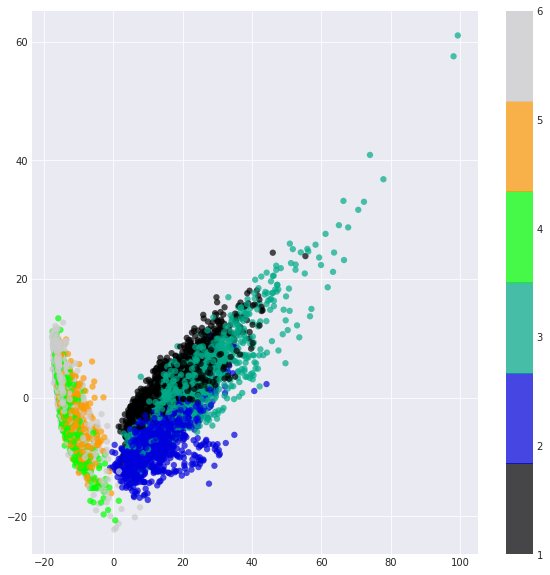

In [38]:
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.colorbar()
plt.show()

Обучите модель `K-means`, используя сжатые наблюдения (`X_pca`), параметры:
- n_clusters = number of clusters
- n_init = 100
- random_state = RANDOM_STATE

In [40]:
kmeans = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE).fit(X_pca)

Визуализируйте данные, используя первые 2 компоненты, но теперь окрасьте точки в соответствии с построенным разбиением.

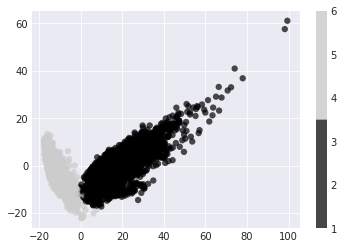

In [41]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 2))
plt.colorbar()
plt.show()

Посмотрим на соответствие между метками и построенными кластерами

In [42]:
tab = pd.crosstab(y, kmeans.labels_, margins=True)
tab.index = list(labels_mapping.values()) + ['all']
tab.columns = [f'cluster_{i+1}' for i in range(6)] + ['all']
tab

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,all
walking,0,77,903,0,742,0,1722
walking upstairs,2,5,1242,0,295,0,1544
walking downstairs,0,196,321,0,889,0,1406
sitting,451,0,1,91,0,1234,1777
standing,566,0,0,0,0,1340,1906
laying down,330,0,5,1556,0,53,1944
all,1349,278,2472,1647,1926,2627,10299


Можно увидеть, что каждый класс попал в несколько кластеров. Давайте рассмотрим максимальный процент объектов в классе, которые попали в один кластер. Например, если в классе 1406 примеров и разбиение на классы:
- 900
- 500
- 6  
то значений такой метрики будет $\frac{900}{1406} \approx 0.64$

Такая простая метрика показывает, насколько класс отделим от других.

Посчитайте такую метрику для каждого класса.

**Вопрос 4.** Отсортируйте класс в порядке уменьшения метрики. В качестве ответа, укажите номера классов через пробел

1 - walking, 2 - walking upstairs, 3 - walking downstairs, 4 - sitting, 5 - standing, 6 - laying down

Возможно, что 6 $-$ не лучшее число кластеров. Определите с помощью метода "локтя", оптимальное число кластеров.

**Вопрос 5.** Какое число кластеров оптимально?

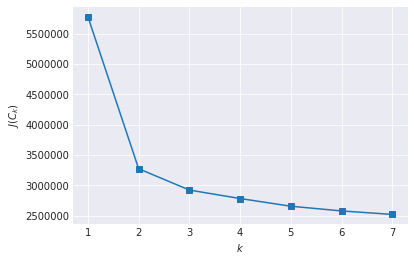

In [43]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_pca)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

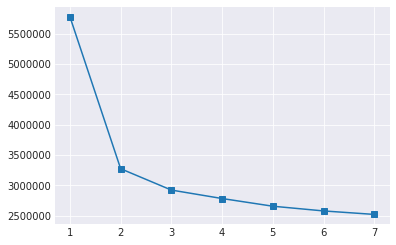

In [44]:
plt.plot(range(1, 8), inertia, marker='s');

Давайте попробуем другой тип кластеризации $-$ агломеративную кластеризацию.

Обучите её на сжатых данных, в качестве количества кластеров укажите число классов, а параметр `linkage` $-$ `ward`

In [45]:
ag = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(X_pca)

Сравните полученную модель с `K-means` из 4 вопроса с помощью метрики $ARI$

In [46]:
print('KMeans: ARI =', metrics.adjusted_rand_score(Y, kmeans.labels_))
print('Agglomerative CLustering: ARI =', metrics.adjusted_rand_score(y, ag.labels_))

KMeans: ARI = 0.43716906963606766
Agglomerative CLustering: ARI = 0.4598748901093879


**Вопрос 6.** Выберите верные утверждения

- Согласно $ARI$, агломеративная кластеризация работает лучше, чем k-means;
- Если перенумеровать классы, то значение метрики не изменится;
- Для случайного разделения на классы, метрика будет близка к 0;
- Метрику $ARI$ можно использовать, даже когда нет истинных меток класса.

Для определения типа активности можно решать и задачу мультиклассовой классификации, так как уже известны метки классов. Воспользуемся моделью `LinearSVC`, а для подбора оптимальных параметров будем использовать поиск по сетке и кросс-валидацию. Почитать про это можно [тут](https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f).

- Используйте `StandartScaler` для стандартизирования данных, но обучите его только на тренировочных данных
- Подберите параметр `C` с помощью `GridSearchCV`, параметр `cv` установите 3

In [47]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [50]:

X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
best_svc = GridSearchCV(estimator=svc, param_grid=svc_params, cv=3)
best_svc.fit(X_train_scaled, y_train)

C:\Users\gleb3\Miniconda3\envs\assignment_1\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\gleb3\Miniconda3\envs\assignment_1\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\gleb3\Miniconda3\envs\assignment_1\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\gleb3\Miniconda3\envs\assignment_1\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\gleb3\Miniconda3\envs\assignment_1\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarni

GridSearchCV(cv=3, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=7, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [53]:
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, 0.9382506099134881)

**Вопрос 7.** Какой оптимальный параметр?

In [54]:
y_predicted = best_svc.predict(X_test_scaled)

In [55]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = list(labels_mapping.values()) + ['all']
tab.columns = list(labels_mapping.values()) + ['all']


tab

,walking,walking upstairs,walking downstairs,sitting,standing,laying down,all
walking,479,11,4,2,0,0,496
walking upstairs,4,465,1,1,0,0,471
walking downstairs,1,2,416,1,0,0,420
sitting,0,4,0,433,52,2,491
standing,0,0,0,16,516,0,532
laying down,0,0,0,0,6,531,537
all,484,482,421,453,574,533,2947


Посчитайте снова метрику отделимости каждого класса.

**Вопрос 8.** Линейный классификатор справился лучше, чем k-means?

**Вопрос 9.** Какая активность хуже всего распознаётся линейным классификатором?

**Вопрос 10.** Выберите верные утверждения

- PCA позволяет ускорить время обучения, но качество, как правило, становится хуже;
- С помощью PCA можно визуализировать данные на плоскости, но это не единственный способ, например, можно использовать t-SNE;
- Каждая компонента PCA $-$ это линейная комбинация исходных параметров.